In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import DeiTForImageClassification, DeiTFeatureExtractor
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
teacher = DeiTForImageClassification.from_pretrained(
    "facebook/deit-base-distilled-patch16-224"
)
teacher.classifier = nn.Linear(teacher.classifier.in_features, 10).to(device)
teacher.to(device).eval().eval()

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DeiTForImageClassification(
  (deit): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
          

In [23]:
student = timm.create_model(
    'tiny_vit_5m_224.dist_in22k',
    pretrained=True,
    num_classes=10
).to(device)

In [24]:
extractor = DeiTFeatureExtractor.from_pretrained(
    "facebook/deit-base-distilled-patch16-224"
)

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_ds = datasets.CIFAR10(root='./../data', train=True, download=True, transform=transform)
test_ds = datasets.CIFAR10(root='./../data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:27<00:00, 6.26MB/s] 


In [25]:
def distillation_loss(s_logits, t_logits, labels, T=2.0, alpha=0.7):
    ce = F.cross_entropy(s_logits, labels)
    kl = F.kl_div(
        F.log_softmax(s_logits / T, dim=1),
        F.softmax(t_logits / T, dim=1),
        reduction="batchmean"
    ) * (T * T)
    return alpha * ce + (1 - alpha) * kl

optimizer = optim.AdamW(student.parameters(), lr=5e-5)

In [26]:
epochs = 5
train_losses, train_accs = [], []

for ep in range(epochs):
    student.train()
    total_loss = correct = total = 0

    for imgs, labels in tqdm(train_loader, desc=f"Train ep{ep+1}"):
        labels = labels.to(device)
        pil_imgs = [transforms.ToPILImage()(img) for img in imgs]

        inputs = extractor(images=pil_imgs, return_tensors="pt")
        pixel_values = inputs['pixel_values'].to(device)

        with torch.no_grad():
            t_logits = teacher(pixel_values=pixel_values).logits

        s_logits = student(pixel_values)
        loss = distillation_loss(s_logits, t_logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = s_logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100 * correct / total
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f"Epoch {ep+1}: Loss={avg_loss:.4f}, Acc={avg_acc:.2f}%")

Train ep1: 100%|██████████| 3125/3125 [07:09<00:00,  7.27it/s]


Epoch 1: Loss=0.6667, Acc=88.13%


Train ep2: 100%|██████████| 3125/3125 [06:51<00:00,  7.60it/s]


Epoch 2: Loss=0.5100, Acc=96.24%


Train ep3: 100%|██████████| 3125/3125 [06:54<00:00,  7.54it/s]


Epoch 3: Loss=0.4836, Acc=97.77%


Train ep4: 100%|██████████| 3125/3125 [06:53<00:00,  7.55it/s]


Epoch 4: Loss=0.4702, Acc=98.46%


Train ep5: 100%|██████████| 3125/3125 [11:48<00:00,  4.41it/s]

Epoch 5: Loss=0.4612, Acc=99.02%


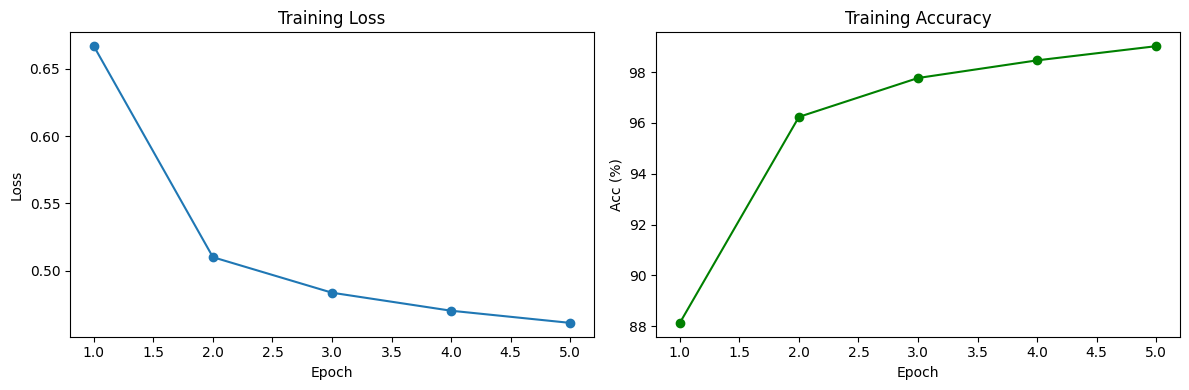

In [27]:
epochs_list = list(range(1, epochs+1))
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs_list, train_losses, '-o')
plt.title("Training Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(epochs_list, train_accs, '-o', color='green')
plt.title("Training Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Acc (%)")
plt.tight_layout()
plt.show()

In [31]:
student.eval()
correct = total = 0
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Test"):
        labels = labels.to(device)
        pil_imgs = [transforms.ToPILImage()(img) for img in imgs]
        inputs = extractor(images=pil_imgs, return_tensors="pt").to(device)

        pixel_values = inputs["pixel_values"].to(device)

        s_logits = student(pixel_values)
        preds = s_logits.argmax(dim=1)
        correct += (preds == labels).sum().item()

        total += labels.size(0)

print(f"\n🎯 Final Test Accuracy: {100 * correct / total:.2f}%")

Test: 100%|██████████| 313/313 [00:51<00:00,  6.11it/s]


🎯 Final Test Accuracy: 97.17%
